In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# FEATURE ATTACK

In [40]:
dset_avg = pd.DataFrame()
for dset in ['CTU', 'ToN_IoT']:
    all_avgs = pd.DataFrame()
    for model in ['rf', 'egraphsage', 'linegraphsage']:
        concats = pd.DataFrame()
        if dset == 'CTU':
            atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
        else:
            # atks = ['ddos', 'backdoor', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
            atks = ['backdoor', 'injection', 'password', 'ransomware', 'scanning', 'xss']
        
        for atk in atks:
            if model == 'rf':
                baseline = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
                attack = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/feature_attack.csv", index_col=0)
            else:
                baseline = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
                attack = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_feature_recall.csv", index_col=0)
        
            attack.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9]
            avg_data = pd.concat([baseline.loc['0', ['recall']].rename({'recall': 0}), attack.mean()]).to_frame()
            concats = pd.concat([concats, avg_data], axis=1)
            
        all_avgs = pd.concat([all_avgs,
                            concats.mean(axis=1).to_frame().assign(frame=f"{model}".capitalize()).rename(columns={'frame': 'Model'})])
    dset_avg = pd.concat([dset_avg, all_avgs.assign(frame=f'{dset}')])
dset_avg

,0,Model,frame
0,0.998969,Rf,CTU
1,0.693335,Rf,CTU
2,0.523715,Rf,CTU
3,0.262457,Rf,CTU
4,0.250114,Rf,CTU
5,0.244041,Rf,CTU
6,0.226775,Rf,CTU
7,0.165392,Rf,CTU
8,0.136229,Rf,CTU
9,0.128220,Rf,CTU


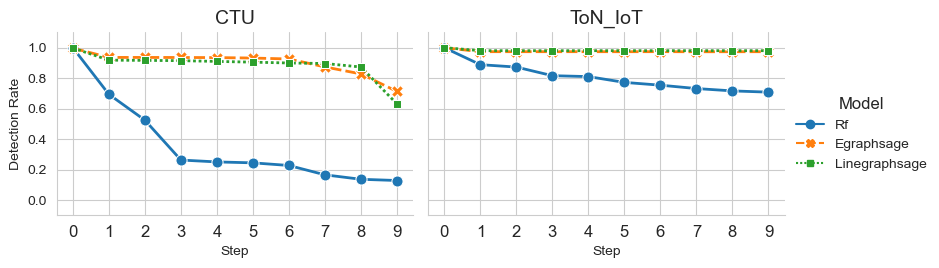

In [46]:
data_to_plot = dset_avg.reset_index().rename(columns={'index': 'Step', 0: 'Detection Rate', 'frame': 'DSet'})
sns.set_style('whitegrid')
g = sns.relplot(data_to_plot, x='Step', y='Detection Rate', hue='Model', height=2.7, aspect=1.5, style='Model', col='DSet', kind='line', markers=True, markersize=8, linewidth=2)
xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
g.set(xticks=xticks, ylim=[-0.1, 1.1], yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
g.set_xticklabels(size=12)
g.set_titles(col_template='{col_name}', size=14)
plt.setp(g._legend.get_title(), fontsize=12)
g.fig.savefig('figures/total/feature_attacks.pdf')

# ADD EDGE ATTACK

In [3]:
def produce_plot_data(baseline_dict, atk_dict, all_metrics = False):
    plot_data = pd.DataFrame()
    for key, df in atk_dict.items():
        baseline_data = baseline_dict[key]
        base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}
        ),
            baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
                {'precision': 'Ben Precision',
                'recall': 'Ben Recall',
                'f1-score': 'Ben F1-Score'}
            )], axis = 0).to_frame().T
        atk_df = pd.concat([base_data, atk_dict[key]], axis = 0)
        if not all_metrics:
            atk_df.drop(columns=['Mal Precision', 'Mal F1-Score', 'Ben Recall', 'Ben Precision', 'Ben F1-Score'], inplace=True)
            
        atk_df = pd.melt(atk_df, var_name='metric', ignore_index=False)
        atk_df['Step'] = list(range(len([0, 1, 2, 5, 10, 20]))) * (len(atk_df) // 6)
        atk_df['Botnet'] = key.capitalize()
        
        plot_data = pd.concat([plot_data, atk_df])
    
    plot_data.rename(columns={'value': 'Detection Rate'}, inplace=True)
    return plot_data

In [44]:
def produce_plot_relplot(plot_data):
    plot_data.rename(columns={'frame': 'Model', 'Step': 'β Step'}, inplace=True)
    grid = sns.relplot(plot_data, x='β Step', y='Detection Rate', hue='Botnet', col='Botnet', kind='line', linewidth=2,
                       style='Model', col_wrap=7, palette='tab20', height=1.5, markers=['o', 'X'], markersize = 8, dashes=True, legend=True)
    xticks = [0, 1, 2, 5, 10, 20]
    grid.set(xticks=xticks, yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
             xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])
    
    for ax in grid.axes.flat:
        ax.xaxis.set_ticks(range(len(xticks)))
        ax.xaxis.set_ticklabels(xticks)
        ax.tick_params(labelbottom=True)

    
    grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=14)
    grid.fig.tight_layout(w_pad = 1)
    
    grid.legend.remove()
    grid.fig.legend(handles=grid.legend.legendHandles[-3:], loc=7, bbox_to_anchor=(0.5, 0.1, 0.5, 0.5)) # (0.4, -0.05, 0.5, 0.5)
    return grid.fig

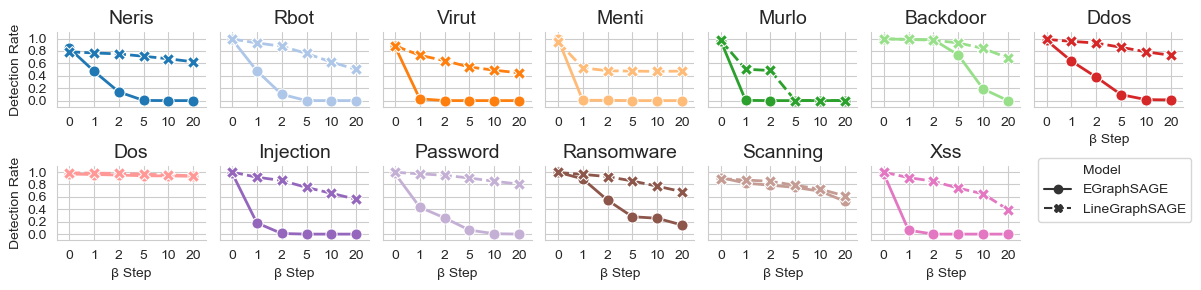

In [45]:
atk_type = 'benign' #malicious

sns.set_style('whitegrid')
model = 'egraphsage'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}_from_C.csv", index_col=0)
        
e_graphsage_data = produce_plot_data(baseline_dict, atk_dict)
    
model = 'linegraphsage'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}_from_C.csv", index_col=0)
        
linegraphsage_data = produce_plot_data(baseline_dict, atk_dict)

data = pd.concat([
    e_graphsage_data.assign(frame='EGraphSAGE'),
    linegraphsage_data.assign(frame='LineGraphSAGE')
])

fig = produce_plot_relplot(data)
fig.savefig(f"figures/total/{atk_type}_from_C_big.pdf")

# ADD NODE ATTACK

In [39]:
def produce_add_node_data(baseline_dict, atk_dict, all_metrics = False):
    plot_data = pd.DataFrame()
    for key, df in atk_dict.items():
        baseline_data = baseline_dict[key]
        base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}
        ),
            baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
                {'precision': 'Ben Precision',
                'recall': 'Ben Recall',
                'f1-score': 'Ben F1-Score'}
            )], axis = 0).to_frame().T
        atk_df = pd.concat([base_data, atk_dict[key]], axis = 0)
        atk_df.reset_index(inplace=True)
        atk_df.rename(columns={'index': 'Step'}, inplace=True)
        atk_df = atk_df[atk_df['Num Nodes'] != 2]
        atk_df = atk_df[atk_df['Num Nodes'] != 20]
        atk_df = atk_df[atk_df['Num Nodes'] != 50]
        atk_df = atk_df[atk_df['Num Nodes'] != 200]
        atk_df.fillna(0.0, inplace=True)
        
        if not all_metrics:
            atk_df.drop(columns=['Mal Precision', 'Mal F1-Score', 'Ben Recall', 'Ben Precision', 'Ben F1-Score'], inplace=True)
            
        atk_df = pd.melt(atk_df, id_vars = ['Step', 'Num Nodes'], value_vars=['Mal Recall'], var_name='metric')
        atk_df['Botnet'] = key.capitalize()
        
        baseline = atk_df[atk_df.Step == 0]
        atk_df = atk_df[atk_df.Step != 0]
        for step in [1, 5, 20]:
            tmp = baseline.copy()
            tmp['Num Nodes'] = 0
            tmp['Step'] = step
            atk_df = pd.concat([atk_df, tmp], axis=0)
        
        atk_df = atk_df.sort_values('Num Nodes')
        atk_df = atk_df[atk_df.Step != 2]
        atk_df = atk_df[atk_df.Step != 10]
        atk_df['Num Nodes'] = atk_df['Num Nodes'].astype(str)
        plot_data = pd.concat([plot_data, atk_df])
    plot_data.rename(columns={'Step': '# Flows'}, inplace=True)
    
    # display(plot_data.head(30))
    plot_data.rename(columns={'value': 'Detection Rate'}, inplace=True)
    return plot_data

def produce_plot_all_addnode(plot_data):
    plot_data.rename(columns={'Num Nodes': 'Num Nodes η', '# Flows': '# Flows γ'}, inplace=True)
    grid = sns.relplot(plot_data, x='Num Nodes η', y='Detection Rate', hue='Botnet', col='Botnet', kind='line', linewidth=2,
                       style='# Flows γ', col_wrap=7, palette='tab20', height=1.5, markers=True, dashes=True, markersize = 8, legend=True)
    xticks = [0, 1, 5, 10, 100, 1000]
    grid.set(xticks=xticks, yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
             xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])

    for ax in grid.axes.flat:
        ax.xaxis.set_ticks(range(len(xticks)))
        labels = [str(x) for x in [0, 1, 5, 10, 100, '1k']]
        ax.xaxis.set_ticklabels(labels)
        ax.tick_params(labelbottom=True)

    grid.set_titles(col_template="{col_name}", row_template="{row_name}", size=14)
    grid.fig.tight_layout(w_pad = 1)
    
    grid.legend.remove()
    grid.fig.legend(handles=grid.legend.legendHandles[-4:], loc=7, bbox_to_anchor=(0.47, 0.05, 0.5, 0.5)) # (0.47, 0.05, 0.5, 0.5) (0.4, -0.05, 0.5, 0.5)
    return grid.fig

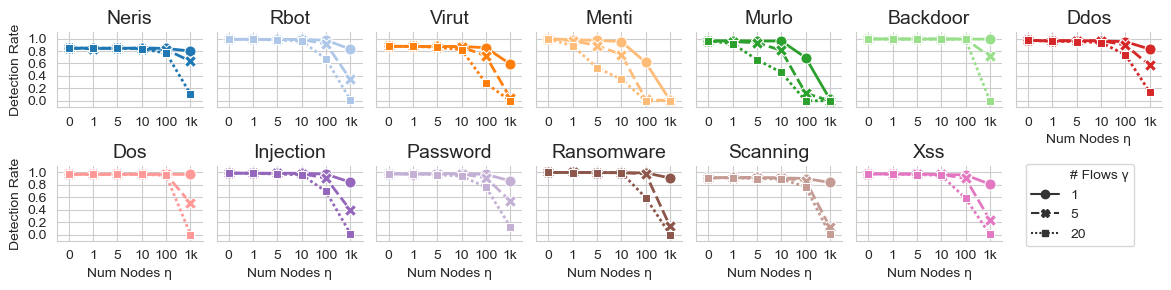

In [41]:
model = 'egraphsage'
sns.set_style('whitegrid')
atk_type = 'add_node'
baseline_dict = {}
atk_dict = {}
for dset in ['CTU', 'ToN_IoT']:
    if dset == 'ToN_IoT':
        atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
    else:
        atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
    for atk in atks:
        baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
        atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}.csv", index_col=0)
        
e_graphsage_data = produce_add_node_data(baseline_dict, atk_dict)
fig = produce_plot_all_addnode(e_graphsage_data)
fig.savefig(f"figures/total/{model}_{atk_type}_big.pdf")

In [208]:
def plot_all_adv_feature(dict_df):
    data = pd.DataFrame()
    for key, df in dict_df.items():
        df_atk = pd.melt(df.T, var_name="Group", value_name="F1 Score")
        step_list = list(range(1, 10)) * (len(df_atk) // 9)
        df_atk['Step'] = step_list
        df_atk['Botnet'] = key
        data = pd.concat([data, df_atk], axis = 0)
        
    grid = sns.FacetGrid(data, col = "Group", hue = "Group", row = "Botnet",
                         palette = 'tab20c', height = 1.5, margin_titles=True)
    
    grid.set(xticks=[1, 3, 5, 7, 9], yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ylim = [-0.1, 1.1])
    grid.set_titles(col_template="{col_name}", row_template="{row_name}")
    grid.fig.tight_layout(w_pad=1)
    
    for ax in grid.axes.flat:
        ax.tick_params(labelbottom = True)
        
    grid.map(plt.plot, 'Step', 'F1 Score', marker = 'o')
    
    plt.show()

In [56]:
data.head()

,metric,Detection Rate,Step,Botnet,frame
0,Mal Recall,0.846350,0,Neris,EGraphSAGE
1,Mal Recall,0.458850,1,Neris,EGraphSAGE
2,Mal Recall,0.314179,2,Neris,EGraphSAGE
5,Mal Recall,0.213647,3,Neris,EGraphSAGE
10,Mal Recall,0.333380,4,Neris,EGraphSAGE


,metric,Detection Rate,Step,Botnet
0,Mal Recall,0.84635,0,Neris
1,Mal Recall,0.47500,1,Neris
2,Mal Recall,0.14045,2,Neris
5,Mal Recall,0.00265,3,Neris
10,Mal Recall,0.00000,4,Neris


,metric,Detection Rate,Step,Botnet
0,Mal Recall,0.846350,0,Neris
1,Mal Recall,0.458850,1,Neris
2,Mal Recall,0.314179,2,Neris
5,Mal Recall,0.213647,3,Neris
10,Mal Recall,0.333380,4,Neris


,metric,Detection Rate,Step,Botnet
0,Mal Recall,0.787049,0,Neris
1,Mal Recall,0.767551,1,Neris
2,Mal Recall,0.752071,2,Neris
5,Mal Recall,0.714529,3,Neris
10,Mal Recall,0.673610,4,Neris


,metric,Detection Rate,Step,Botnet
0,Mal Recall,0.787049,0,Neris
1,Mal Recall,0.571903,1,Neris
2,Mal Recall,0.491819,2,Neris
5,Mal Recall,0.437418,3,Neris
10,Mal Recall,0.469189,4,Neris


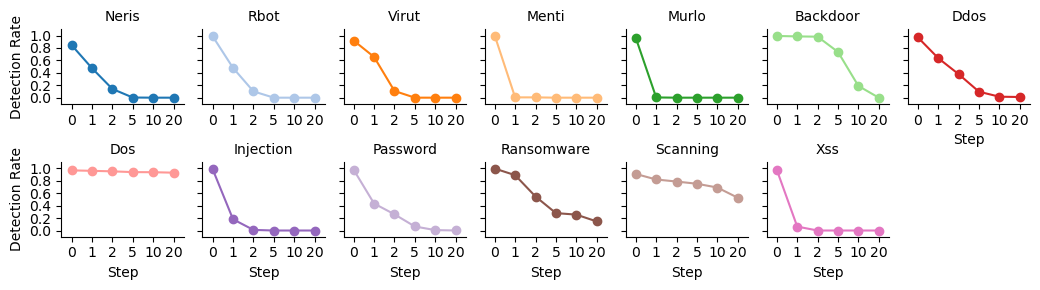

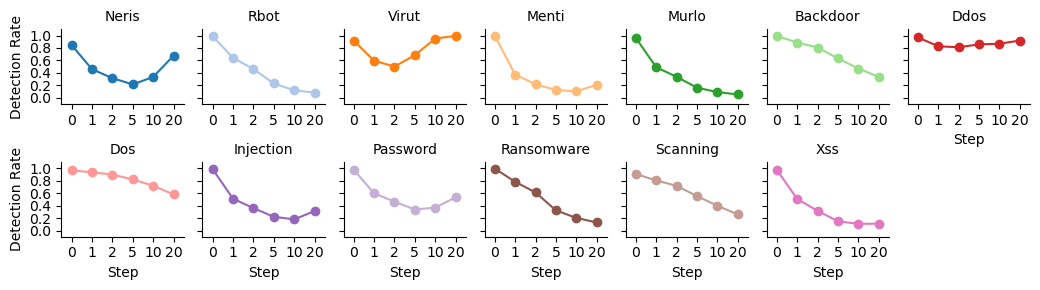

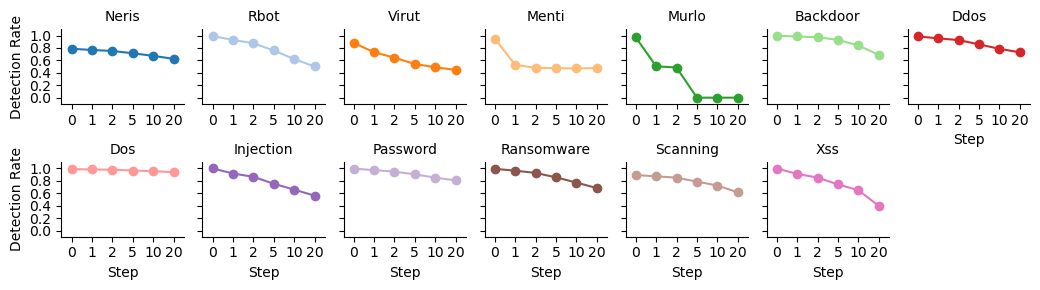

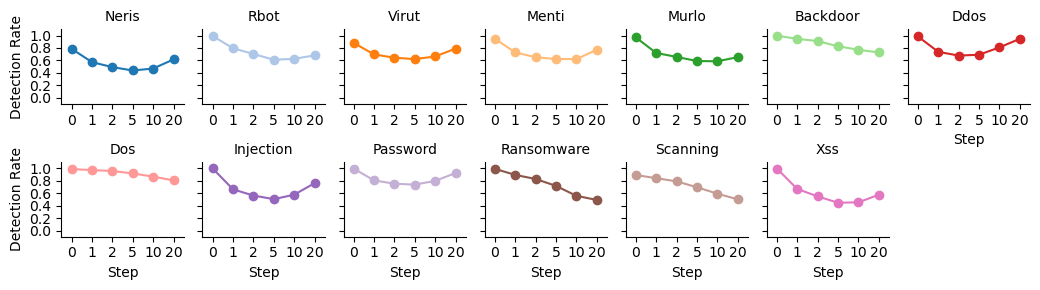

In [51]:
for model in ['egraphsage', 'linegraphsage']:
    for atk_type in ['benign', 'malicious']:
        baseline_dict = {}
        atk_dict = {}
        for dset in ['CTU', 'ToN_IoT']:
            if dset == 'ToN_IoT':
                atks = ['backdoor', 'ddos', 'dos', 'injection', 'password', 'ransomware', 'scanning', 'xss']
            else:
                atks = ['neris', 'rbot', 'virut', 'menti', 'murlo']
            for atk in atks:
                baseline_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/baseline.csv", index_col=0)
                atk_dict[atk] = pd.read_csv(f"results/{dset}/scores/{model}/{atk}/aa_structure_{atk_type}_from_C.csv", index_col=0)
                

        fig = plot_all_adv_structure(baseline_dict, atk_dict)
        #fig.savefig(f"figures/total/{model}_{atk_type}_from_C.pdf")


In [12]:
data = pd.read_csv("preprocessed_data/CTU/murlo_train.csv")
mal = data[data.Label == 1]
ben = data[data.Label == 0]

print(f'Benigns: {len(ben)}')
print(f'Malicious: {len(mal)}')
print(f'Ratio: {len(ben) / len(mal)}')

Benigns: 15998
Malicious: 800
Ratio: 19.9975


In [13]:
from utils import get_batch, get_batch_test

batch = get_batch(data)

In [14]:
for i, d in enumerate(get_batch(data)):
    mal_batch = d[d.Label == 1]
    ben_batch = d[d.Label == 0]
    print(f'Benigns: {len(ben_batch)}')
    print(f'Malicious: {len(mal_batch)}')
    print(f'Ratio: {len(ben_batch) / len(mal_batch)}')

Benigns: 8000
Malicious: 800
Ratio: 10.0


In [13]:
len(d[d.Label == 0]) / len(d[d.Label == 1])

11.7096018735363

In [2]:
data = pd.read_csv("datasets/CTU/neris.csv")

/tmp/ipykernel_11853/237392257.py:1: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("datasets/CTU/neris.csv")


In [10]:
data.SrcAddr.value_counts()

147.32.84.165    84694
147.32.84.192    20305
147.32.84.204    18783
147.32.84.191    18774
147.32.84.206    18553
147.32.84.193    17961
147.32.84.208    17909
147.32.84.205    17535
147.32.84.209    16376
147.32.84.207    15999
Name: SrcAddr, dtype: int64

In [3]:
data.dtypes

StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos         float64
dTos         float64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label          int64
dtype: object

In [4]:
data2 = pd.read_csv("datasets/CTU/menti.csv")

In [8]:
data2.Proto.value_counts()

tcp    4600
udp      30
Name: Proto, dtype: int64

In [5]:
data.dtypes

StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos         float64
dTos         float64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label          int64
dtype: object

In [6]:
data = pd.read_csv("results/scores/murlo/aa_feature_f1.csv", index_col=0)

In [7]:
data.head()

,0,1,2,3,4,5,6,7,8
1a,0.945326,0.937063,0.945326,0.950355,0.948673,0.946996,0.950355,0.948673,0.950355
1b,0.946996,0.946996,0.948673,0.943662,0.946996,0.946996,0.950355,0.950355,0.946903
1c,0.946996,0.946996,0.950355,0.933798,0.948673,0.946996,0.946996,0.943662,0.950266
1d,0.933798,0.950355,0.943662,0.946996,0.946996,0.950089,0.950000,0.000000,0.000000
2a,0.950355,0.946996,0.953737,0.942004,0.946996,0.946996,0.950355,0.946996,0.946996


In [45]:
df = pd.DataFrame()
for c in data.T.columns:
    series = data.T.loc[:, c].to_frame()
    series.rename(columns={c: 'F1 score'}, inplace=True)
    series['Group'] = c
    df = pd.concat([df, series], axis=0)

df.reset_index(inplace=True)
df.rename(columns={'index': 'Step'}, inplace=True)
df['Step'] = df['Step'].astype(np.int64)
df['Step'] += 1
df.head(10)

,Step,F1 score,Group
0,1,0.945326,1a
1,2,0.937063,1a
2,3,0.945326,1a
3,4,0.950355,1a
4,5,0.948673,1a
5,6,0.946996,1a
6,7,0.950355,1a
7,8,0.948673,1a
8,9,0.950355,1a
9,1,0.946996,1b


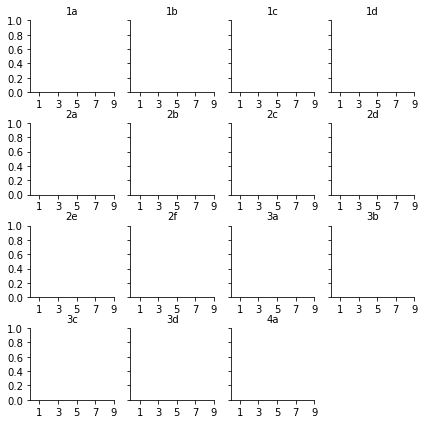

In [82]:
grid = sns.FacetGrid(df, col = 'Group', hue = 'Group', palette = 'tab20c', col_wrap = 4, height=1.5)
grid.set(xticks=[1, 3, 5, 7, 9], yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid.set_titles(col_template="{col_name}")
grid.fig.tight_layout(w_pad=1)

for ax in grid.axes.flat:
    ax.tick_params(labelbottom=True)

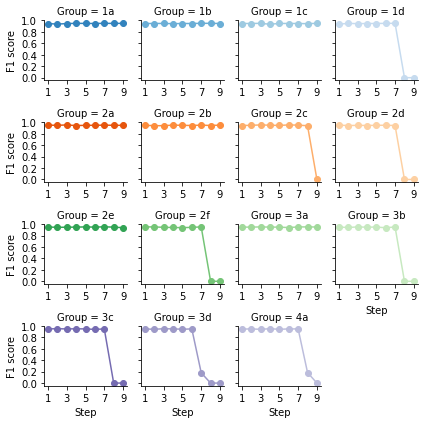

In [83]:
grid.map(plt.plot, 'Step', 'F1 score', marker = 'o')

In [2]:
data_murlo = pd.read_csv("results/scores/murlo/aa_feature_f1.csv", index_col = 0)
data_rbot = pd.read_csv("results/scores/rbot/aa_feature_f1.csv", index_col = 0)

In [16]:
df_murlo = pd.melt(data_murlo.T, var_name="Group", value_name="F1 Score")
# df_murlo.reset_index(inplace=True)
step_list = list(range(1, 10)) * (len(df_murlo) // 9)
df_murlo['Step'] = step_list

In [17]:
df_murlo

,Group,F1 Score,Step
0,1a,0.945326,1
1,1a,0.937063,2
2,1a,0.945326,3
3,1a,0.950355,4
4,1a,0.948673,5
...,...,...,...
130,4a,0.940351,5
131,4a,0.946996,6
132,4a,0.946619,7
133,4a,0.184211,8


In [19]:
dict_df = {'Murlo': data_murlo, 'Rbot': data_rbot}
data = pd.DataFrame()
for key, df in dict_df.items():
    df_atk = pd.melt(df.T, var_name="Group", value_name="F1 Score")
    step_list = list(range(1, 10)) * (len(df_atk) // 9)
    df_atk['Step'] = step_list
    df_atk['Botnet'] = key
    data = pd.concat([data, df_atk], axis = 0)

In [20]:
data

,Group,F1 Score,Step,Botnet
0,1a,0.945326,1,Murlo
1,1a,0.937063,2,Murlo
2,1a,0.945326,3,Murlo
3,1a,0.950355,4,Murlo
4,1a,0.948673,5,Murlo
...,...,...,...,...
130,4a,0.983903,5,Rbot
131,4a,0.982460,6,Rbot
132,4a,0.980904,7,Rbot
133,4a,0.974436,8,Rbot


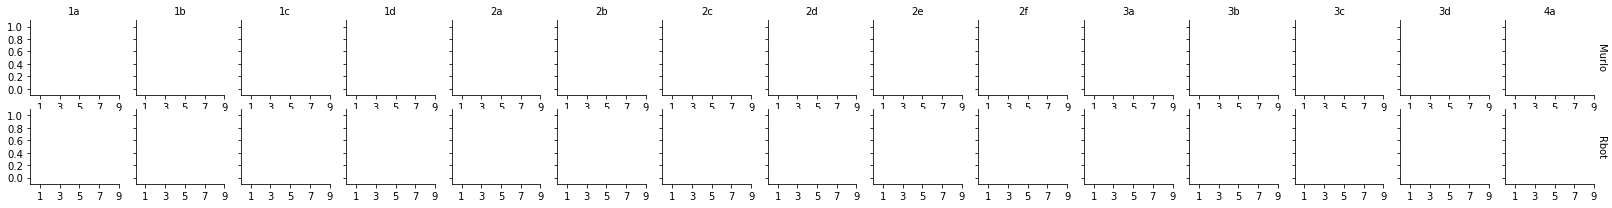

In [27]:
grid = sns.FacetGrid(data, col = 'Group', hue = 'Group', row = 'Botnet',
                     palette = 'tab20c', height=1.5, margin_titles=True)
grid.set(xticks=[1, 3, 5, 7, 9], yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ylim = [-0.1, 1.1])
grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.fig.tight_layout(w_pad=1)

for ax in grid.axes.flat:
    ax.tick_params(labelbottom=True)

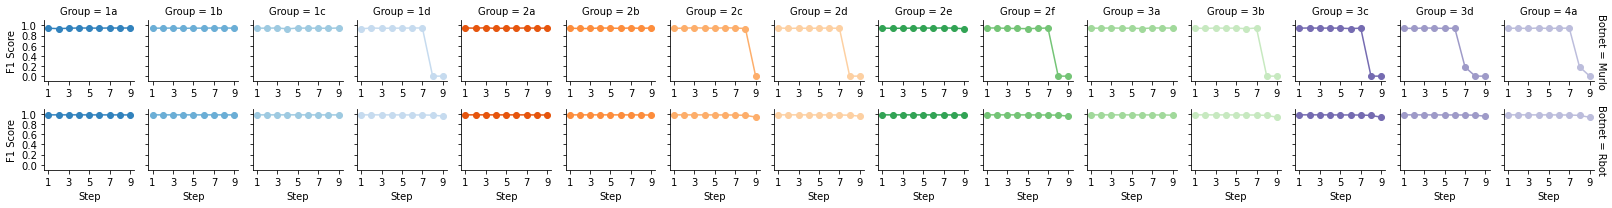

In [28]:
grid.map(plt.plot, 'Step', 'F1 Score', marker = 'o')

Structure adversarial plot

In [29]:
baseline_data = pd.read_csv("results/scores/murlo/baseline.csv", index_col=0)
atk_data = pd.read_csv("results/scores/murlo/aa_structure_malicious_from_C.csv", index_col=0)

In [30]:
baseline_data.head()

,precision,recall,f1-score,support
0,0.998513,0.997216,0.997864,10776.000000
1,0.946996,0.971014,0.958855,552.000000
accuracy,0.995939,0.995939,0.995939,0.995939
macro avg,0.972755,0.984115,0.978360,11328.000000
weighted avg,0.996003,0.995939,0.995963,11328.000000


In [33]:
atk_data.head()

,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
1,0.486264,0.949911,0.643247,0.997402,0.950393,0.973330
2,0.320466,0.938959,0.477844,0.996845,0.906421,0.949485
5,0.150369,0.933206,0.259004,0.996752,0.795394,0.884761
10,0.092070,0.901316,0.167073,0.994432,0.664764,0.796847
20,0.056378,0.861373,0.105829,0.990442,0.499088,0.663723


In [43]:
pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}), 
           baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Ben Precision',
             'recall': 'Ben Recall',
             'f1-score': 'Ben F1-Score'})], axis = 0).to_frame().T

,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
0,0.971014,0.946996,0.958855,0.997216,0.998513,0.997864


In [47]:
base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Mal Precision',
             'recall': 'Mal Recall',
             'f1-score': 'Mal F1-Score'}), 
           baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
            {'precision': 'Ben Precision',
             'recall': 'Ben Recall',
             'f1-score': 'Ben F1-Score'})], axis = 0).to_frame().T

In [48]:
base_data

,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
0,0.971014,0.946996,0.958855,0.997216,0.998513,0.997864


In [70]:
atk_df = pd.melt(atk_data, var_name="metric", ignore_index=False)
# atk_df.reset_index(inplace=True)
# atk_df.rename(columns={'index': 'Step'}, inplace=True)
# atk_df['Step'] = atk_df['Step'].astype(np.int64)
atk_df['Step'] = list(range(len([0, 1, 2, 5, 10, 20]))) * (len(atk_df)//6)
atk_df.head()

,metric,value,Step
0,Mal Recall,0.971014,0
1,Mal Recall,0.486264,1
2,Mal Recall,0.320466,2
5,Mal Recall,0.150369,3
10,Mal Recall,0.092070,4


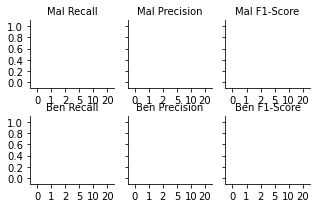

In [71]:
grid = sns.FacetGrid(atk_df, col = 'metric', hue = 'metric', col_wrap=3,
                     palette = 'tab20c', height=1.5, margin_titles=True)
xticks = [0, 1, 2, 5, 10, 20]
grid.set(xticks=xticks, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
         xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])
grid.set_titles(col_template="{col_name}")
grid.fig.tight_layout(w_pad=1)

for ax in grid.axes.flat:
    ax.xaxis.set_ticks(range(len(xticks)))
    ax.xaxis.set_ticklabels(xticks)
    ax.tick_params(labelbottom=True)

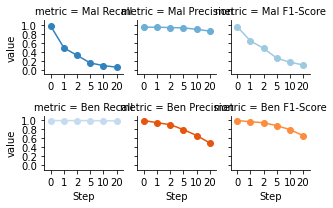

In [72]:
grid.map(plt.plot, 'Step', 'value', marker = 'o')

In [96]:
atk_baseline_dict = {'Murlo': pd.read_csv("results/scores/murlo/baseline.csv", index_col=0),
                     'Rbot': pd.read_csv("results/scores/rbot/baseline.csv", index_col=0)}
atk_ben_dict = {'Murlo': pd.read_csv('results/scores/murlo/aa_structure_benign_from_C.csv', index_col=0),
                'Rbot': pd.read_csv("results/scores/rbot/aa_structure_benign_from_C.csv", index_col=0)}
atk_mal_dict = {'Murlo': pd.read_csv('results/scores/murlo/aa_structure_malicious_from_C.csv', index_col=0),
                     'Rbot': pd.read_csv("results/scores/rbot/aa_structure_malicious_from_C.csv", index_col=0)}

ben_plot_data = pd.DataFrame()
mal_plot_data = pd.DataFrame()
for key, df in atk_ben_dict.items():
    baseline_data = atk_baseline_dict[key]
    base_data = pd.concat([baseline_data.loc['1', ['recall', 'precision', 'f1-score']].rename(
                            {'precision': 'Mal Precision',
                            'recall': 'Mal Recall',
                            'f1-score': 'Mal F1-Score'}), 
                            baseline_data.loc['0', ['recall', 'precision', 'f1-score']].rename(
                                {'precision': 'Ben Precision',
                                'recall': 'Ben Recall',
                                'f1-score': 'Ben F1-Score'})], axis = 0).to_frame().T
    atk_ben_df = pd.concat([base_data, atk_ben_dict[key]], axis=0)
    atk_ben_df = pd.melt(atk_ben_df, var_name="metric", ignore_index=False)
    atk_ben_df['Step'] = list(range(len([0, 1, 2, 5, 10, 20]))) * (len(atk_ben_df)//6)
    atk_ben_df['Botnet'] = key
    # atk_ben_dict[key] = atk_ben_df
    
    atk_mal_df = pd.concat([base_data, atk_mal_dict[key]], axis=0)
    atk_mal_df = pd.melt(atk_mal_df, var_name="metric", ignore_index=False)
    atk_mal_df['Step'] = list(range(len([0, 1, 2, 5, 10, 20]))) * (len(atk_mal_df)//6)
    atk_mal_df['Botnet'] = key
    # atk_mal_dict[key] = atk_mal_df
    
    ben_plot_data = pd.concat([ben_plot_data, atk_ben_df])
    mal_plot_data = pd.concat([mal_plot_data, atk_mal_df])


In [97]:
ben_plot_data

,metric,value,Step,Botnet
0,Mal Recall,0.971014,0,Murlo
1,Mal Recall,0.000000,1,Murlo
2,Mal Recall,0.000000,2,Murlo
5,Mal Recall,0.000000,3,Murlo
10,Mal Recall,0.000000,4,Murlo
...,...,...,...,...
1,Ben F1-Score,0.986056,1,Rbot
2,Ben F1-Score,0.976466,2,Rbot
5,Ben F1-Score,0.976178,3,Rbot
10,Ben F1-Score,0.978675,4,Rbot


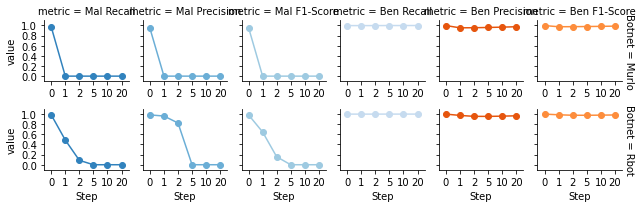

In [103]:
grid = sns.FacetGrid(ben_plot_data, col = 'metric', hue = 'metric', row = 'Botnet',
                     palette = 'tab20c', height=1.5, margin_titles=True)
xticks = [0, 1, 2, 5, 10, 20]
grid.set(xticks=xticks, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
         xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])
grid.set_titles(col_template="{col_name}")
grid.fig.tight_layout(w_pad=1)

for ax in grid.axes.flat:
    ax.xaxis.set_ticks(range(len(xticks)))
    ax.xaxis.set_ticklabels(xticks)
    ax.tick_params(labelbottom=True)
    
grid.map(plt.plot, 'Step', 'value', marker = 'o')

In [101]:
for k, df in atk_ben_dict.items():
    print(k)
    display(df)

Murlo


,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
1,0.0,0.0,0.0,0.997349,0.953371,0.974864
2,0.0,0.0,0.0,0.997554,0.955408,0.976026
5,0.0,0.0,0.0,0.998590,0.960597,0.979225
10,0.0,0.0,0.0,0.998516,0.966954,0.982482
20,0.0,0.0,0.0,0.999258,0.975036,0.986999


Rbot


,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
1,0.487204,0.960992,0.646596,0.998951,0.973489,0.986056
2,0.086811,0.824017,0.157074,0.999042,0.954887,0.976466
5,0.000000,0.000000,0.000000,0.999215,0.954180,0.976178
10,0.000000,0.000000,0.000000,0.999314,0.958871,0.978675
20,0.000000,0.000000,0.000000,0.999481,0.965861,0.982384


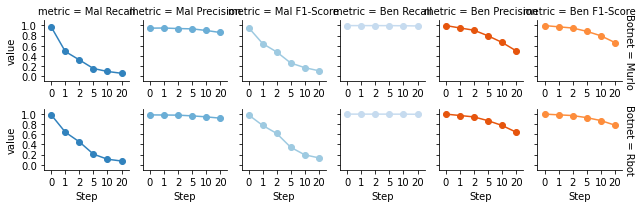

In [104]:
grid = sns.FacetGrid(mal_plot_data, col = 'metric', hue = 'metric', row = 'Botnet',
                     palette = 'tab20c', height=1.5, margin_titles=True)
xticks = [0, 1, 2, 5, 10, 20]
grid.set(xticks=xticks, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
         xlim = [-0.5, 5.5], ylim = [-0.1, 1.1])
grid.set_titles(col_template="{col_name}")
grid.fig.tight_layout(w_pad=1)

for ax in grid.axes.flat:
    ax.xaxis.set_ticks(range(len(xticks)))
    ax.xaxis.set_ticklabels(xticks)
    ax.tick_params(labelbottom=True)
    
grid.map(plt.plot, 'Step', 'value', marker = 'o')

In [102]:
for k, df in atk_mal_dict.items():
    print(k)
    display(df)

Murlo


,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
1,0.486264,0.949911,0.643247,0.997402,0.950393,0.973330
2,0.320466,0.938959,0.477844,0.996845,0.906421,0.949485
5,0.150369,0.933206,0.259004,0.996752,0.795394,0.884761
10,0.092070,0.901316,0.167073,0.994432,0.664764,0.796847
20,0.056378,0.861373,0.105829,0.990442,0.499088,0.663723


Rbot


,Mal Recall,Mal Precision,Mal F1-Score,Ben Recall,Ben Precision,Ben F1-Score
1,0.642573,0.981682,0.776728,0.999021,0.971630,0.985135
2,0.451687,0.978453,0.618058,0.998918,0.943677,0.970512
5,0.209278,0.964649,0.343939,0.998542,0.869161,0.929370
10,0.108899,0.944908,0.195291,0.997932,0.774689,0.872253
20,0.073238,0.919277,0.135667,0.996161,0.642946,0.781496
